# Imports

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib as mpl
import matplotlib.pyplot as plt
import ptitprince as pt
from matplotlib.colors import ListedColormap
import matplotlib.gridspec as gridspec
from Bio import AlignIO
import warnings
import mdtraj as md
from pylab import *
from scipy.optimize import curve_fit
from scipy import stats
from sklearn.metrics import roc_curve, auc, roc_auc_score
from scipy.stats import bootstrap
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import biotite.structure as struc
from scipy.stats import sem
from matplotlib.offsetbox import AnchoredText
import urllib.request
from Bio import PDB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from matplotlib.cm import ScalarMappable
import matplotlib.colors as mcolors



warnings.filterwarnings('ignore')

# Functions

In [2]:
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['axes.labelsize']  = 16
mpl.rcParams['legend.fontsize'] = 14

In [3]:
def remove_WT_score(score,WT_seq):
    for i in range(len(WT_seq)):
        score[i,alphabetAA_L_D[WT_seq[i]]-1]=np.nan
    return score

In [4]:
def load_rosetta(data,wt_seq,gap):
    df=pd.read_excel("data/additional_file2.xlsx",sheet_name=data)
    mutation_load=np.array(df.iloc[:,0])
    score_load=np.array(df.iloc[:,1])
    scores=np.empty((len(wt_seq),20),dtype=float)
    scores[:]=np.nan
    count=1
    for i in range(len(wt_seq)):
            if wt_seq[i]!='-':
                for j in range(len(mutation_load)):
                    if int(mutation_load[j][1:len(mutation_load[j])-1])==count and mutation_load[j][len(mutation_load[j])-1]!= '=':
                        scores[i, alphabetAA_L_D[mutation_load[j][len(mutation_load[j])-1]]-1]= float(score_load[j])
            count+=1
    return scores

In [5]:
def load_data(data,wt_seq,start_gap=0):
    df=pd.read_csv(data, delim_whitespace=True, comment='#')
    mutation_load=np.array(df.iloc[:,0])
    score_load=np.array(df.iloc[:,1])
    scores=np.empty((len(wt_seq),20),dtype=float)
    scores[:]=np.nan
    for i in range(len(mutation_load)):
        if  mutation_load[i][len(mutation_load[i])-1]!= '=':
            scores[int(mutation_load[i][1:len(mutation_load[i])-1])-1+start_gap, alphabetAA_L_D[mutation_load[i][len(mutation_load[i])-1]]-1]= float(score_load[i])
    return scores

In [6]:
def heatmap_scores_reordered(ext_score,label_cm,WT_mask,lim_down,lim_up,color,x,WT_cmap='gnuplot_r',nan_cmap='Dark2_r',figs=[30,9],xtick_spacing=50):
    mpl.rcParams['xtick.labelsize'] = 18
    mpl.rcParams['ytick.labelsize'] = 18
    mpl.rcParams['axes.labelsize']  = 20

    score=np.copy(ext_score)

    for i in range(score.shape[1]):
        #print(i,score[:,i][0:10])
        score[:,alphabetAA_D_D_reordered[i]]=ext_score[:,i]
        #print(alphabetAA_D_D_reordered[i],score[:,alphabetAA_D_D_reordered[i]][0:10])

    score_nan=np.copy(ext_score)
    score_nan[:]=np.inf
    
    for i in range(score.shape[0]):
        for j in range(score.shape[1]):
                if np.isnan(ext_score[i,j])==True and WT_mask[i]!=alphabetAA_D_L[j+1]:
                    
                    score_nan[i,alphabetAA_D_D_reordered[j]]=1
                    #print(WT_mask[i],alphabetAA_D_D_reordered[alphabetAA_D_L[j+1]])
            
    fig, ax = plt.subplots(figsize=(figs[0],figs[1]))
    ylabels=[ alphabetAA_L_D_reordered[i] for i in range(0,20)]
    current_cmap = mpl.cm.get_cmap()
    current_cmap.set_bad(color='gray')
 
    pos=ax.imshow(np.transpose(score), aspect = 'auto', cmap=color,
                 vmin=lim_down,vmax=lim_up,interpolation='nearest')
    
    current_cmap = mpl.cm.get_cmap()
    current_cmap.set_bad(color='gray')
    fig.colorbar(pos, label=label_cm)

    ax.set_yticks([i for i in range(0,20)])
    ax.set_yticklabels(ylabels)
    
    #xlabels = [1] + np.arange(10,len(GCK_WT_sequence)-1,10).tolist()
    #ax.xaxis.set_ticks(np.arange(1, len(GCK_WT_sequence)-1, 10))
    #ax.set_xticklabels(xlabels)
    
    x_labels= ['1','50', '100', '150','200','250', '300', '350',  '400', '450']

    ax.set_xticks([0, 49, 99, 149, 199, 249, 299, 349, 399, 449])
    ax.set_xticklabels(x_labels)


    #plt.grid(axis='both',which='both',alpha=0.4)
    #plt.ylabel("mutation")
    plt.xlabel("Position")
    plt.ylim(-0.5,19.5)
    plt.xlim(x[0]-0.5,x[1]+0.5)
    start, end = ax.get_xlim()
    #ax.xaxis.set_ticks(np.arange(start+0.5, end, xtick_spacing))
    ax.tick_params(axis='x',rotation=90)
    ax.tick_params(axis='y',rotation=90)
    tmp=np.empty((len(WT_mask),20),dtype=float)
    tmp[:]=np.inf
    for i in range(0,len(WT_mask)):
        tmp[i,alphabetAA_D_D_reordered[alphabetAA_L_D[WT_mask[i]]-1]]=1
    
    print(score_nan[0,:])
    plt.imshow(score_nan.T, cmap=nan_cmap, aspect = 'auto',interpolation='nearest')
    plt.imshow(tmp.T, cmap=WT_cmap, aspect = 'auto',interpolation='nearest')
    

In [7]:
def print_chimera_x_attribute_file(attribute_check,attribute,file,model_id='#1',chain_id='/A',argument='cbyvalue'):
    file=open(file,"w+")
    file.write('%s\n%s\n%s\n%s\n' % ('#','#  Use this file to assign the attribute in Chimera with the','#  Define Attribute tool or the command defattr','#'))
    file.write('%s%s\n%s\n%s\n' % ( 'attribute: ',argument,'match mode: 1-to-1', 'recipient: residues') )
    for i in range(len(attribute_check)):
        if np.isnan(attribute_check[i])==True or attribute_check[i]==-99999:
            pass
        else:
            file.write("\t%s%s%s%d\t%f\n" % (str(model_id),str(chain_id),':',i+1,attribute[i]))
    file.close()

In [8]:
alphabetAA_L_D={'-':0,'_' :0,'A':1,'C':2,'D':3,'E':4,'F':5,'G':6,'H':7,'I':8,'K':9,'L':10,'M':11,'N':12,'P':13,'Q':14,'R':15,'S':16,'T':17,'V':18,'W':19,'Y':20}
alphabetAA_D_L={v: k for k, v in alphabetAA_L_D.items()}
               
alphabetAA_3L_1L={"Ter":'*', "=":"=", "Gap":'-',"Ala":'A',"Cys":'C',"Asp":'D',"Glu":'E',"Phe":'F',"Gly":'G',"His":'H',"Ile":'I',"Lys":'K',"Leu":'L',"Met":'M',"Asn":'N',"Pro":'P',"Gln":'Q',"Arg":'R',"Ser":'S',"Thr":'T',"Val" :'V',"Trp":'W',"Tyr":'Y'}
alphabetAA_1L_3L={v: k for k,v in alphabetAA_3L_1L.items()}

alphabetAA_L_D_reordered={0:'R',1:'H',2:'K',3:'D',4:'E',5:'S',6:'T',7:'N',8:'Q',9:'C',10:'G',11:'P',12:'A',13:'V',14:'I',15:'L',16:'M',17:'F',18:'Y',19:'W'}
alphabetAA_D_D_reordered={14:0,6:1,8:2,2:3,3:4,15:5,16:6,11:7,13:8,1:9,5:10,12:11,0:12,17:13,7:14,9:15,10:16,4:17,19:18,18:19}

In [9]:
def score_histogram(score,nbin,color,label_x,norm_bool,thr):                   
    #plot the distribution of the input data (can be a vector or matrix)
    #three different normalization option: off, density (matplotlib standard normalization), True: Frobenius-norm based 
    # thr: threshold for count the variants under a custom threshold
    
    mpl.rcParams['figure.figsize']=(9,7)    
    mpl.rcParams['axes.axisbelow'] = True
    mpl.rcParams['xtick.labelsize'] = 18
    mpl.rcParams['ytick.labelsize'] = 18
    
    if norm_bool=='Density':
        n, bins, patches = plt.hist(score[~np.isnan(score)], bins=nbin, facecolor=color, alpha=0.7,edgecolor="black",density=True)
        plt.ylabel('Normalized counts',fontsize=20)
    elif norm_bool=='True':
        counts, bins = np.histogram(score[~np.isnan(score)],bins=nbin)
        norm= counts / np.linalg.norm(counts)
        plt.hist(bins[:-1], bins, weights=norm, facecolor=color, alpha=0.7,edgecolor="black")
        plt.ylabel('Normalized counts',fontsize=20)
    else:
        n, bins, patches = plt.hist(score[~np.isnan(score)], bins=nbin, facecolor=color,edgecolor="black")
        plt.ylabel('Counts',fontsize=20)

    plt.xlabel(label_x,fontsize=20)
    plt.xticks(fontsize=18)
    plt.grid(axis="y",alpha=0.4,linestyle='--')
    sum_under=0
    for i in range(len(bins)-1):
        if bins[i+1] < thr:
            sum_under+=counts[i]
    print('over threshold variants:',np.sum(counts)-sum_under, ' (', (np.sum(counts)-sum_under)/np.sum(counts)*100 ,'%)')
    

In [10]:
GCK_WT_sequence="MLDDRARMEAAKKEKVEQILAEFQLQEEDLKKVMRRMQKEMDRGLRLETHEEASVKMLPTYVRSTPEGSEVGDFLSLDLGGTNFRVMLVKVGEGEEGQWSVKTKHQMYSIPEDAMTGTAEMLFDYISECISDFLDKHQMKHKKLPLGFTFSFPVRHEDIDKGILLNWTKGFKASGAEGNNVVGLLRDAIKRRGDFEMDVVAMVNDTVATMISCYYEDHQCEVGMIVGTGCNACYMEEMQNVELVEGDEGRMCVNTEWGAFGDSGELDEFLLEYDRLVDESSANPGQQLYEKLIGGKYMGELVRLVLLRLVDENLLFHGEASEQLRTRGAFETRFVSQVESDTGDRKQIYNILSTLGLRPSTTDCDIVRRACESVSTRAAHMCSAGLAGVINRMRESRSEDVMRITVGVDGSVYKLHPSFKERFHASVRRLTPSCEITFIESEEGSGRGAALVSAVACKKACMLGQ"
GCK_WT_ros_seq1='--------------MVEQILAEFQLQEEDLKKVMRRMQKEMDRGLRLETHEEASVKMLPTYVRSTPEGSEVGDFLSLDLGGTNFRVMLVKVGEGEEGQWSVKTKHQMYSIPEDAMTGTAEMLFDYISECISDFLDKHQMKHKKLPLGFTFSFPVRH-----------------------NVVGLLRDAIKRRGDFEMDVVAMVNDTVATMISCYYEDHQCEVGMIVGTGCNACYMEEMQNVELVEGDEGRMCVNTEWGAFGDSGELDEFLLEYDRLVDESSANPGQQLYEKLIGGKYMGELVRLVLLRLVDENLLFHGEASEQLRTRGAFETRFVSQVESDTGDRKQIYNILSTLGLRPSTTDCDIVRRACESVSTRAAHMCSAGLAGVINRMRESRSEDVMRITVGVDGSVYKLHPSFKERFHASVRRLTPSCEITFIESEEGSGRGAALVSAVACKKAC----'
GCK_WT_ros_seq2='-------------TLVEQILAEFQLQEEDLKKVMRRMQKEMDRGLRLETHEEASVKMLPTYVRSTPEGSEVGDFLSLDLGGTNFRVMLVKVGEGEEGQWSVKTKHQMYSIPEDAMTGTAEMLFDYISECISDFLDKHQMKHKKLPLGFTFSFPVRHEDIDKGILLNWTKGFKASGAEGNNVVGLLRDAIKRRGDFEMDVVAMVNDTVATMISCYYEDHQCEVGMIVGTGCNACYMEEMQNVELVEGDEGRMCVNTEWGAFGDSGELDEFLLEYDRLVDESSANPGQQLYEKLIGGKYMGELVRLVLLRLVDENLLFHGEASEQLRTRGAFETRFVSQVESDTGDRKQIYNILSTLGLRPSTTDCDIVRRACESVSTRAAHMCSAGLAGVINRMRESRSEDVMRITVGVDGSVYKLHPSFKERFHASVRRLTPSCEITFIESEEGSGRGAALVSAVACKKAC----'

In [11]:
def correlation_plot(x,y,x_label='score1',y_label='score2',nan_value=-99999):
    
    def func(x, a, b):
        return a * x + b
    
    rng = np.random.default_rng()
    
    fig, ax = plt.subplots(1,1,figsize=(8,8))    
    
    bad = ~np.logical_or(np.isnan(x), np.isnan(y)) 
    
    x_t=np.compress(bad, x)
    y_t=np.compress(bad, y)

    xy= np.vstack([x_t,y_t])
    z = sp.stats.gaussian_kde(xy)(xy)
    
    idx = z.argsort()
    
    ax.grid(alpha=0.3)
    ax.set_ylabel(y_label)
    ax.set_xlabel(x_label)
    x_s, y_s, z = x_t[idx], y_t[idx], z[idx]
    ax.scatter(x_s, y_s, c=z, s=100,cmap='viridis')
        
    #stats

    
    print("pearson's r:", pearson_output(x_s,y_s))
    
    #correlation line

    
    optimizedParameters, pcov = curve_fit(func, x_s, y_s);
    
    ax.plot(x_s,func(x_s, *optimizedParameters),'r' ,label="fit" )
    
    ## bootstrap statistic
    
    res = bootstrap((x_s, y_s), pearson_output, vectorized=False, paired=True,
                random_state=rng)
    
    print("boostraping confidence interval:", res.confidence_interval)
    

In [12]:
def pearson_output(x,y):
    return sp.stats.pearsonr(x,y)[0]

In [13]:
def spearman_output(x,y):
    return sp.stats.spearmanr(x,y)[0]

In [14]:
def split_hgvs_pro(df):
    '''Takes a pd df as input and splits the hgvs_pro column into reference and variant residue, as well as the position'''

    df[['p', 'aa']] = df.hgvs_pro.str.split('.' ,expand=True)
    df[['aa_ref_3', 'aa_var_3']] = df.aa.str.split('\d+',expand=True)
    df[['position']] = df['hgvs_pro'].str.extract('(\d+)').astype(int)
    del df['aa']
    del df['p']
    df['aa_var'] = df['aa_var_3'].map(alphabetAA_3L_1L)
    df['aa_ref'] = df['aa_ref_3'].map(alphabetAA_3L_1L)
    df['variant'] = df['aa_ref'] + df['position'].map(str) + df['aa_var']
    
    return df



# Load data

## Y2H

In [15]:
df_mave= pd.read_excel("data/additional_file2.xlsx",sheet_name="interaction_scores")

mutation_load=np.array(df_mave.iloc[:,0])
score_load=np.array(df_mave.iloc[:,1])
errors_load=np.array(df_mave.iloc[:,2])

GCK_scores=np.empty((len(GCK_WT_sequence),20),dtype=float)
GCK_scores[:]=np.nan

GCK_errors=np.empty((len(GCK_WT_sequence),20),dtype=float)
GCK_errors[:]=np.nan

for i in range(len(mutation_load)):
    if  mutation_load[i][len(mutation_load[i])-1]!= '=' and mutation_load[i][-3:] != 'Ter' :
        GCK_scores[int(mutation_load[i][5:len(mutation_load[i])-3])-1, alphabetAA_L_D[alphabetAA_3L_1L[mutation_load[i][-3:]]]-1]= float(score_load[i])
        GCK_errors[int(mutation_load[i][5:len(mutation_load[i])-3])-1, alphabetAA_L_D[alphabetAA_3L_1L[mutation_load[i][-3:]]]-1]= float(errors_load[i])

In [16]:
GCK_scores_med=np.nanmedian(GCK_scores,axis=1)

In [17]:
GCK_synonymous_mutations=np.empty((len(GCK_WT_sequence),1),dtype=float)
GCK_synonymous_mutations[:]=np.nan

GCK_stop_mutations=np.empty((len(GCK_WT_sequence),1),dtype=float)
GCK_stop_mutations[:]=np.nan

for i in range(len(mutation_load)):
    if  mutation_load[i][len(mutation_load[i])-1]=='=':
        GCK_synonymous_mutations[int(mutation_load[i][5:len(mutation_load[i])-1])-1, 0]= float(score_load[i])
        
    elif mutation_load[i][-3:] == 'Ter' :
        GCK_stop_mutations[int(mutation_load[i][5:len(mutation_load[i])-3])-1, 0]= float(score_load[i])

## Y2H data using only variants with an se below 0.3 and scores capped at 1

In [18]:
df_mave_low_se = df_mave.copy()
df_mave_low_se = df_mave_low_se[df_mave_low_se['se'] < 0.3]
df_mave_low_se['score_interaction'] = df_mave_low_se['score_interaction'].clip(upper=1)

mutation_load_low_se=np.array(df_mave_low_se.iloc[:,0])
score_load_low_se=np.array(df_mave_low_se.iloc[:,1])
errors_load_low_se=np.array(df_mave_low_se.iloc[:,2])

GCK_scores_low_se=np.empty((len(GCK_WT_sequence),20),dtype=float)
GCK_scores_low_se[:]=np.nan

GCK_errors_low_se=np.empty((len(GCK_WT_sequence),20),dtype=float)
GCK_errors_low_se[:]=np.nan

for i in range(len(mutation_load_low_se)):
    if  mutation_load_low_se[i][len(mutation_load_low_se[i])-1]!= '=' and mutation_load_low_se[i][-3:] != 'Ter' :
        GCK_scores_low_se[int(mutation_load_low_se[i][5:len(mutation_load_low_se[i])-3])-1, alphabetAA_L_D[alphabetAA_3L_1L[mutation_load_low_se[i][-3:]]]-1]= float(score_load_low_se[i])
        GCK_errors_low_se[int(mutation_load_low_se[i][5:len(mutation_load_low_se[i])-3])-1, alphabetAA_L_D[alphabetAA_3L_1L[mutation_load_low_se[i][-3:]]]-1]= float(errors_load_low_se[i])
        
GCK_scores_med_low_se=np.nanmedian(GCK_scores_low_se,axis=1)

GCK_synonymous_mutations_low_se=np.empty((len(GCK_WT_sequence),1),dtype=float)
GCK_synonymous_mutations_low_se[:]=np.nan

GCK_stop_mutations_low_se=np.empty((len(GCK_WT_sequence),1),dtype=float)
GCK_stop_mutations_low_se[:]=np.nan

for i in range(len(mutation_load_low_se)):
    if  mutation_load_low_se[i][len(mutation_load_low_se[i])-1]=='=':
        GCK_synonymous_mutations_low_se[int(mutation_load_low_se[i][5:len(mutation_load_low_se[i])-1])-1, 0]= float(score_load_low_se[i])
        
    elif mutation_load_low_se[i][-3:] == 'Ter' :
        GCK_stop_mutations_low_se[int(mutation_load_low_se[i][5:len(mutation_load_low_se[i])-3])-1, 0]= float(score_load_low_se[i])

        
sp.nanstd(GCK_synonymous_mutations_low_se.flatten())

0.14502011768987402

## Y2H data using only variants with an se below 0.3 and uncapped

In [19]:
df_mave_low_se_uncapped = df_mave.copy()
df_mave_low_se_uncapped = df_mave_low_se_uncapped[df_mave_low_se_uncapped['se'] < 0.3]

mutation_load_low_se_uncapped=np.array(df_mave_low_se_uncapped.iloc[:,0])
score_load_low_se_uncapped=np.array(df_mave_low_se_uncapped.iloc[:,1])
errors_load_low_se_uncapped=np.array(df_mave_low_se_uncapped.iloc[:,2])

GCK_scores_low_se_uncapped=np.empty((len(GCK_WT_sequence),20),dtype=float)
GCK_scores_low_se_uncapped[:]=np.nan

GCK_errors_low_se_uncapped=np.empty((len(GCK_WT_sequence),20),dtype=float)
GCK_errors_low_se_uncapped[:]=np.nan

for i in range(len(mutation_load_low_se_uncapped)):
    if  mutation_load_low_se_uncapped[i][len(mutation_load_low_se_uncapped[i])-1]!= '=' and mutation_load_low_se_uncapped[i][-3:] != 'Ter' :
        GCK_scores_low_se_uncapped[int(mutation_load_low_se_uncapped[i][5:len(mutation_load_low_se_uncapped[i])-3])-1, alphabetAA_L_D[alphabetAA_3L_1L[mutation_load_low_se_uncapped[i][-3:]]]-1]= float(score_load_low_se_uncapped[i])
        GCK_errors_low_se_uncapped[int(mutation_load_low_se_uncapped[i][5:len(mutation_load_low_se_uncapped[i])-3])-1, alphabetAA_L_D[alphabetAA_3L_1L[mutation_load_low_se_uncapped[i][-3:]]]-1]= float(errors_load_low_se_uncapped[i])
        
GCK_scores_med_low_se_uncapped=np.nanmedian(GCK_scores_low_se_uncapped,axis=1)

GCK_synonymous_mutations_low_se_uncapped=np.empty((len(GCK_WT_sequence),1),dtype=float)
GCK_synonymous_mutations_low_se_uncapped[:]=np.nan

GCK_stop_mutations_low_se_uncapped=np.empty((len(GCK_WT_sequence),1),dtype=float)
GCK_stop_mutations_low_se_uncapped[:]=np.nan

for i in range(len(mutation_load_low_se_uncapped)):
    if  mutation_load_low_se_uncapped[i][len(mutation_load_low_se_uncapped[i])-1]=='=':
        GCK_synonymous_mutations_low_se_uncapped[int(mutation_load_low_se_uncapped[i][5:len(mutation_load_low_se_uncapped[i])-1])-1, 0]= float(score_load_low_se_uncapped[i])
        
    elif mutation_load_low_se_uncapped[i][-3:] == 'Ter' :
        GCK_stop_mutations_low_se_uncapped[int(mutation_load_low_se_uncapped[i][5:len(mutation_load_low_se_uncapped[i])-3])-1, 0]= float(score_load_low_se_uncapped[i])

        
sp.nanstd(GCK_synonymous_mutations_low_se_uncapped.flatten())

0.270544597676679

## Activity scores

In [20]:
# Activity scores
df_mave_act= pd.read_excel("data/additional_file2.xlsx",sheet_name="activity_scores")

mutation_load_act=np.array(df_mave_act.iloc[:,0])
score_load_act=np.array(df_mave_act.iloc[:,1])
errors_load_act=np.array(df_mave_act.iloc[:,2])

GCK_scores_act=np.empty((len(GCK_WT_sequence),20),dtype=float)
GCK_scores_act[:]=np.nan

GCK_errors_act=np.empty((len(GCK_WT_sequence),20),dtype=float)
GCK_errors_act[:]=np.nan

for i in range(len(mutation_load_act)):
    if  mutation_load_act[i][len(mutation_load_act[i])-1]!= '=' and mutation_load_act[i][-3:] != 'Ter' :
        GCK_scores_act[int(mutation_load_act[i][5:len(mutation_load_act[i])-3])-1, alphabetAA_L_D[alphabetAA_3L_1L[mutation_load_act[i][-3:]]]-1]= float(score_load_act[i])
        GCK_errors_act[int(mutation_load_act[i][5:len(mutation_load_act[i])-3])-1, alphabetAA_L_D[alphabetAA_3L_1L[mutation_load_act[i][-3:]]]-1]= float(errors_load_act[i])
        

GCK_scores_med_act=np.nanmedian(GCK_scores_act,axis=1)

## Abundance scores

In [21]:
# Abundance scores
df_mave_abu= pd.read_excel("data/additional_file2.xlsx",sheet_name="abundance_scores")

mutation_load_abu=np.array(df_mave_abu.iloc[:,0])
score_load_abu=np.array(df_mave_abu.iloc[:,1])
errors_load_abu=np.array(df_mave_abu.iloc[:,2])

GCK_scores_abu=np.empty((len(GCK_WT_sequence),20),dtype=float)
GCK_scores_abu[:]=np.nan

GCK_errors_abu=np.empty((len(GCK_WT_sequence),20),dtype=float)
GCK_errors_abu[:]=np.nan

for i in range(len(mutation_load_abu)):
    if  mutation_load_abu[i][len(mutation_load_abu[i])-1]!= '=' and mutation_load_abu[i][-3:] != 'Ter' :
        GCK_scores_abu[int(mutation_load_abu[i][5:len(mutation_load_abu[i])-3])-1, alphabetAA_L_D[alphabetAA_3L_1L[mutation_load_abu[i][-3:]]]-1]= float(score_load_abu[i])
        GCK_errors_abu[int(mutation_load_abu[i][5:len(mutation_load_abu[i])-3])-1, alphabetAA_L_D[alphabetAA_3L_1L[mutation_load_abu[i][-3:]]]-1]= float(errors_load_abu[i])
        

GCK_scores_med_abu=np.nanmedian(GCK_scores_abu,axis=1)

## Loading all three assay scores (interaction w. se<0.3)

In [22]:
interaction = pd.read_excel("data/additional_file2.xlsx",sheet_name="interaction_scores")
abundance = pd.read_excel("data/additional_file2.xlsx",sheet_name="abundance_scores")
activity = pd.read_excel("data/additional_file2.xlsx",sheet_name="activity_scores")


In [23]:
# Interaction, abundance and activity data with hgvs_pro column split

split_hgvs_pro(interaction)
split_hgvs_pro(abundance)
split_hgvs_pro(activity)


,hgvs_pro,score_activity,sd,df,se,aa_ref_3,aa_var_3,position,aa_var,aa_ref,variant
0,p.Ala10=,1.145508,0.166775,4,0.083387,Ala,=,10,=,A,A10=
1,p.Ala10Arg,1.484304,0.430744,6,0.175851,Ala,Arg,10,R,A,A10R
2,p.Ala10Asn,1.143163,0.154918,2,0.109544,Ala,Asn,10,N,A,A10N
3,p.Ala10Asp,0.580222,0.115104,2,0.081391,Ala,Asp,10,D,A,A10D
4,p.Ala10Cys,1.823896,0.112859,2,0.079803,Ala,Cys,10,C,A,A10C
...,...,...,...,...,...,...,...,...,...,...,...
9357,p.Val91Ser,0.443489,0.324573,6,0.132506,Val,Ser,91,S,V,V91S
9358,p.Val91Ter,0.102053,0.076292,2,0.053947,Val,Ter,91,*,V,V91*
9359,p.Val91Thr,0.457589,0.335059,2,0.236923,Val,Thr,91,T,V,V91T
9360,p.Val91Trp,0.138357,0.236928,2,0.167533,Val,Trp,91,W,V,V91W


In [24]:
# Merge scores with all variants retained
scores = pd.merge(interaction, abundance, how='outer', on='hgvs_pro')
scores = pd.merge(scores, activity, how='outer', on='hgvs_pro')


In [25]:
# Merge interaction, abundance and activity scores while retaining only variants with all three scores
scores_inner = pd.merge(interaction, abundance, how='inner', on='hgvs_pro')
scores_inner = pd.merge(scores_inner, activity, how='inner', on='hgvs_pro')


In [26]:
# Variants with all three scores and interaction se < 0.3
scores_inner_low_se = scores_inner[scores_inner['se_x'] < 0.3]

# Of these, how many nonsense+missense (excluding synonymous)

len(scores_inner_low_se[scores_inner_low_se['aa_var'] != '='])



7128

In [27]:
# Calculate median scores and add to new df 
median_interaction = scores.groupby('position')['score_interaction'].median().reset_index()
median_abundance = scores.groupby('position')['score_abundance'].median().reset_index()
median_activity = scores.groupby('position')['score_activity'].median().reset_index()

all_positions = pd.DataFrame({'position': range(1, 466)})
med_scores = pd.merge(all_positions, median_interaction, on='position', how='left')
med_scores = pd.merge(med_scores, median_abundance, on='position', how='left')
med_scores = pd.merge(med_scores, median_activity, on='position', how='left')



### Retain only interaction scores w. se<0.3

Make score dataframes where only interaction scores with an se below 0.3 are retained.
These scores are used for all plots.

In [28]:
# scores df w. max interaction se < 0.3
scores_low_se = scores[scores['se_x'] < 0.3]
scores_low_se_uncapped = scores_low_se.copy()

In [29]:
# med_scores df w. max interaction se < 0.3 for individual variants

median_interaction_low_se_uncapped = scores_low_se_uncapped.groupby('position')['score_interaction'].median().reset_index()

all_positions = pd.DataFrame({'position': range(1, 466)})
med_scores_low_se_uncapped = pd.merge(all_positions, median_interaction_low_se_uncapped, on='position', how='left')
med_scores_low_se_uncapped = pd.merge(med_scores_low_se_uncapped, median_abundance, on='position', how='left')
med_scores_low_se_uncapped = pd.merge(med_scores_low_se_uncapped, median_activity, on='position', how='left')


### Cap interaction scores at 1

In [30]:
# cap score df at interaction score = 1
scores_low_se['score_interaction'] = scores_low_se['score_interaction'].clip(upper=1)

In [31]:
# make med_scores_low_se using interaction scores capped on 1

median_interaction_low_se = scores_low_se.groupby('position')['score_interaction'].median().reset_index()

all_positions = pd.DataFrame({'position': range(1, 466)})
med_scores_low_se = pd.merge(all_positions, median_interaction_low_se, on='position', how='left')
med_scores_low_se = pd.merge(med_scores_low_se, median_abundance, on='position', how='left')
med_scores_low_se = pd.merge(med_scores_low_se, median_activity, on='position', how='left')


## Loading stability predictions

In [32]:
# load rosetta scores for 1v4t and remove rows where there is no ddG (for super-open including 157-179 predicted using models)

rosetta_1v4t = pd.read_excel("data/additional_file2.xlsx",sheet_name="ddG_1V4T")
rosetta_1v4t['ddG_1v4t'].replace('', np.nan, inplace=True)
rosetta_1v4t.dropna(subset=['ddG_1v4t'], inplace=True)

In [33]:
rosetta_GCK_1v4t_ddg=load_rosetta("ddG_1V4T",GCK_WT_ros_seq2,0)
rosetta_GCK_1v4t_ddg=remove_WT_score(rosetta_GCK_1v4t_ddg,GCK_WT_sequence)

In [34]:
rosetta_GCK_1v4t_ddg_avg=np.nanmedian(rosetta_GCK_1v4t_ddg,axis=1)

## Loading GKRP data

In [35]:
gkrp_inhibition = pd.read_excel("data/additional_file2.xlsx", sheet_name="GKRP")
# Strip whitespace from variant column
gkrp_inhibition['variant'] = gkrp_inhibition['variant'].str.strip()

# Ensure that inhibition values are floats
gkrp_inhibition['GKRP'] = gkrp_inhibition['GKRP'].str.strip()
gkrp_inhibition['GKRP_S6P'] = gkrp_inhibition['GKRP_S6P'].str.strip()

gkrp_inhibition['GKRP'] = pd.to_numeric(gkrp_inhibition['GKRP'],errors='coerce')
gkrp_inhibition['GKRP_S6P'] = pd.to_numeric(gkrp_inhibition['GKRP_S6P'],errors='coerce')



gkrp_inhibition = pd.merge(gkrp_inhibition, scores_low_se, how='inner', on='variant')

## Loading variants from reverse Y2H

In [36]:
reverse_y2h = pd.read_excel("data/additional_file2.xlsx",sheet_name="reverse_y2h")

reverse_y2h = pd.merge(reverse_y2h, scores_low_se, how='left', on='hgvs_pro')

## gnomAD and disease

In [37]:
gnomad = pd.read_excel("data/additional_file2.xlsx",sheet_name="gnomAD")

gnomad = pd.merge(gnomad, scores_low_se, how='inner', on='hgvs_pro')

In [38]:
disease = pd.read_excel("data/additional_file2.xlsx", sheet_name="disease")

disease = pd.merge(disease, scores_low_se, how='left', on='variant')

In [39]:
disease.loc[disease["disease"] == "Benign"]

,variant,disease,label,hgvs_pro,score_interaction,se_x,df_x,aa_ref_3_x,aa_var_3_x,position_x,...,variant_y,score_activity,sd,df,se,aa_ref_3,aa_var_3,position,aa_var,aa_ref
70,A11T,Benign,1.0,p.Ala11Thr,1.000000,0.215637,8.0,Ala,Thr,11.0,...,A11T,0.657910,0.304151,6.0,0.124169,Ala,Thr,11.0,T,A
71,G68D,Benign,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
72,T342P,Benign,1.0,p.Thr342Pro,0.623123,0.070559,8.0,Thr,Pro,342.0,...,T342P,0.661667,0.254251,4.0,0.127126,Thr,Pro,342.0,P,T
73,E279Q,Benign,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
74,D217N,Benign,1.0,p.Asp217Asn,0.589099,0.160837,4.0,Asp,Asn,217.0,...,D217N,1.002612,0.920779,2.0,0.651089,Asp,Asn,217.0,N,D
75,R46K,Benign,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
76,M462I,Benign,1.0,p.Met462Ile,0.833500,0.099714,4.0,Met,Ile,462.0,...,M462I,1.016289,0.233730,2.0,0.165272,Met,Ile,462.0,I,M
77,E48K,Benign,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
78,D4N,Benign,1.0,p.Asp4Asn,0.839894,0.233416,8.0,Asp,Asn,4.0,...,D4N,1.738514,0.496541,2.0,0.351107,Asp,Asn,4.0,N,D
79,M1L,Benign,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Kinetics

In [40]:
kinetics = pd.read_excel("data/additional_file2.xlsx", sheet_name = "kinetics")

kinetics = pd.merge(kinetics, scores_low_se, how='left', on='hgvs_pro')

## rASA and WCN

In [41]:
# Import rASA calculated using 1v4t
rasa_1v4t = pd.read_excel('data/additional_file2.xlsx', sheet_name='WCN_1V4T')

rasa_1v4t = pd.merge(scores_low_se, rasa_1v4t, how='outer', on='position')


# ChimeraX

In [42]:
# Chimera file for median interaction
med_scores_interaction = med_scores_low_se.score_interaction.to_numpy()
print_chimera_x_attribute_file(med_scores_interaction, med_scores_interaction, 'output/med_scores_interaction_low_se.txt')

In [43]:
# Chimera file for median abundance score
med_scores_abundance = med_scores_low_se.score_abundance.to_numpy()
print_chimera_x_attribute_file(med_scores_abundance, med_scores_abundance, 'output/med_scores_abundance.txt')

In [44]:
# Make column with difference between median interaction and abundance scores, and make chimera file for difference
med_scores_low_se['delta_int_abu'] = med_scores_low_se['score_interaction'] - med_scores_low_se['score_abundance']

med_scores_delta_int_abu = med_scores_low_se.delta_int_abu.to_numpy()
print_chimera_x_attribute_file(med_scores_delta_int_abu, med_scores_delta_int_abu, 'output/delta_int_abu.txt')


# Heatmap Y2H (se<0.3)

In [45]:
# colormap for heatmaps
cmap_full = plt.get_cmap('RdBu')
red_to_white = LinearSegmentedColormap.from_list(
    'RedToWhite',
    cmap_full(np.linspace(0, 0.5, 256))
)

[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. inf  1.
  1.  1.]


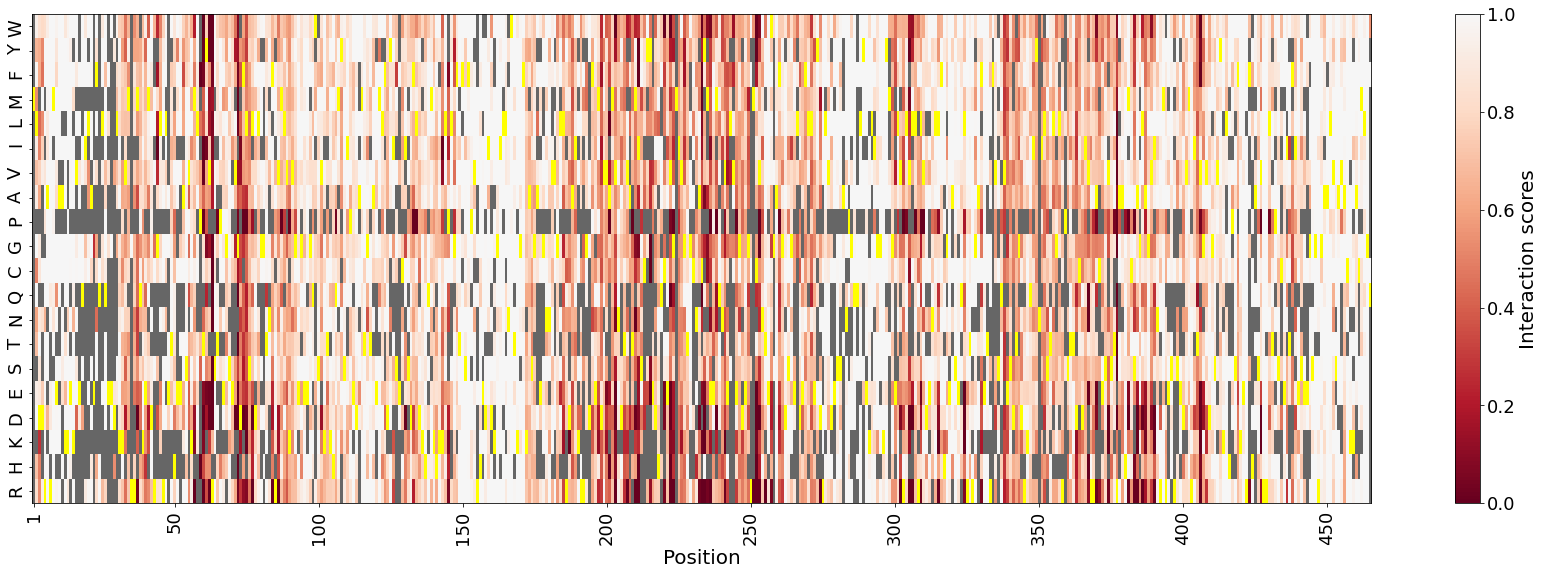

In [46]:
heatmap_scores_reordered(GCK_scores_low_se,'Interaction scores',GCK_WT_sequence,0,1,red_to_white,[0, len(GCK_WT_sequence)-1])


plt.savefig('output/GCK_interaction_map_low_se.pdf',dpi=600, facecolor='w')

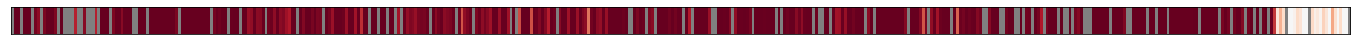

In [47]:
#Nonsense variants
fig, (ax1) = plt.subplots(1,1,figsize=(24,0.5))

cmap = plt.get_cmap(red_to_white)
cmap.set_bad(color = 'grey')

ax1.imshow(GCK_stop_mutations_low_se.reshape(1,-1),aspect= 'auto',cmap=cmap, vmin=0,vmax=1,interpolation='nearest')
ax1.set_yticks([])
ax1.set_xticks([])
ax1.set_xlim(-0.5,len(GCK_WT_sequence)-1+0.5)

plt.savefig('output/GCK_interaction_nonsense_low_se.pdf',dpi=600, facecolor='w')

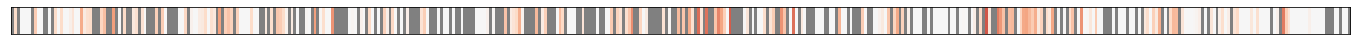

In [48]:
# Synonymous variants
fig, (ax1) = plt.subplots(1,1,figsize=(24,0.5))

cmap = plt.get_cmap(red_to_white)
cmap.set_bad(color = 'grey')

ax1.imshow(GCK_synonymous_mutations_low_se.reshape(1,-1),aspect= 'auto',cmap=cmap, vmin=0,vmax=1,interpolation='nearest')
ax1.set_yticks([])
ax1.set_xticks([])
ax1.set_xlim(-0.5,len(GCK_WT_sequence)-1+0.5)


plt.savefig('output/synonymous_low_error.pdf',dpi=600, facecolor='w')

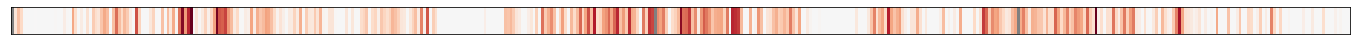

In [49]:
# Median scores
fig, (ax1) = plt.subplots(1,1,figsize=(24,0.5))

cmap = plt.get_cmap(red_to_white)
cmap.set_bad(color = 'grey')

ax1.imshow(GCK_scores_med_low_se.reshape(1,-1),aspect= 'auto',cmap=cmap, vmin=0,vmax=1,interpolation='nearest')
ax1.set_yticks([])
ax1.set_xticks([])
ax1.set_xlim(-0.5,len(GCK_WT_sequence)-1+0.5)

plt.savefig('output/GCK_interaction_median_low_se.pdf',dpi=600, facecolor='w')

# Score distributions

## Interaction score distribution (uncapped)

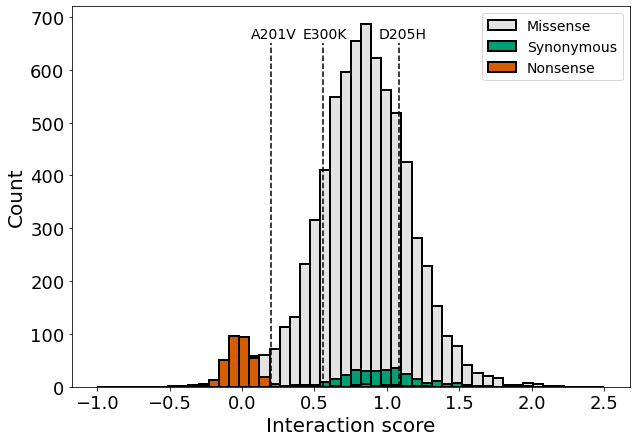

In [50]:
fig, ax = plt.subplots(figsize=(10,7))

ax.hist(GCK_scores_low_se_uncapped.flatten(),bins=50, range=(-1,2.5),facecolor='#e3e3e3',edgecolor='k',lw=2,label='Missense')
ax.hist(GCK_synonymous_mutations_low_se_uncapped
        .flatten(),bins=50,range=(-1,2.5),facecolor='#009E74',edgecolor='k',lw=2,label='Synonymous')
ax.hist(GCK_stop_mutations_low_se_uncapped.flatten(),bins=50,range=(-1,2.5),facecolor='#d55c00',edgecolor='k',lw=2,label='Nonsense')

# Marking S64P
ax.vlines(x=[scores.loc[scores['hgvs_pro'] == 'p.Ala201Val', 'score_interaction'].iloc[0]],ymax=650, ymin=0, colors='black', ls='--')
ax.text(((scores.loc[scores['hgvs_pro'] == 'p.Ala201Val', 'score_interaction'].iloc[0])-0.14), 660, 'A201V', color='black', size=14)


# Marking D205H
ax.vlines(x=[scores.loc[scores['hgvs_pro'] == 'p.Asp205His', 'score_interaction'].iloc[0]],ymax=650, ymin=0, colors='black', ls='--')
ax.text(((scores.loc[scores['hgvs_pro'] == 'p.Asp205His', 'score_interaction'].iloc[0])-0.14), 660, 'D205H', color='black', size=14)

# Marking E300K
ax.vlines(x=[scores.loc[scores['hgvs_pro'] == 'p.Glu300Lys', 'score_interaction'].iloc[0]],ymax=650, ymin=0, colors='black', ls='--')
ax.text(((scores.loc[scores['hgvs_pro'] == 'p.Glu300Lys', 'score_interaction'].iloc[0])-0.14), 660, 'E300K', color='black', size=14)


ax.legend(fontsize=14, loc= "upper right")
ax.set_xlabel('Interaction score')
ax.set_ylabel('Count')

plt.savefig('output/GCK_interaction_score_distribution.png',dpi=600, facecolor='w')

# Median score plots

## Line plot - interaction, abundance

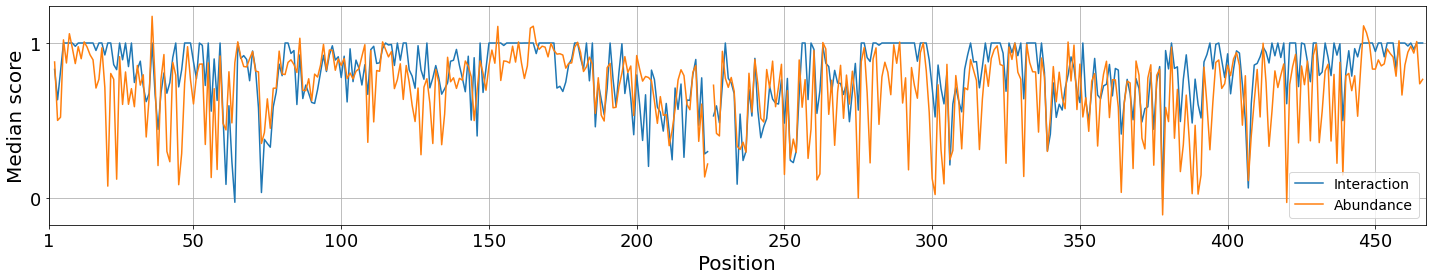

In [51]:
# Create a single subplot with the given figure size
fig, ax = plt.subplots(figsize=(20, 4))

# Plot each line with appropriate data
ax.plot(med_scores_low_se['position'], med_scores_low_se['score_interaction'], label='Interaction')
ax.plot(med_scores_low_se['position'], med_scores_low_se['score_abundance'], label='Abundance')
#ax.plot(med_scores['position'], med_scores['score_activity'], label='Activity')

# Set labels and other plot properties
ax.set_xlabel('Position')
ax.set_ylabel('Median score')
ax.grid(True)
ax.set_xlim(1, 466)
ax.set_yticks([0, 1])
#ax.set_ylim(-0.2, 2)  # Uncomment if you need to set specific y-limits

x_labels= ['1','50', '100', '150','200','250', '300', '350',  '400', '450']
ax.set_xticks([0, 49, 99, 149, 199, 249, 299, 349, 399, 449])
ax.set_xticklabels(x_labels)


# Add legend
ax.legend(fontsize=14, loc='lower right')

# Adjust layout to fit everything
fig.tight_layout()

plt.savefig('output/GCK_int_abu_medians.png',dpi=600, facecolor='w')

## Line plot - interaction, activity

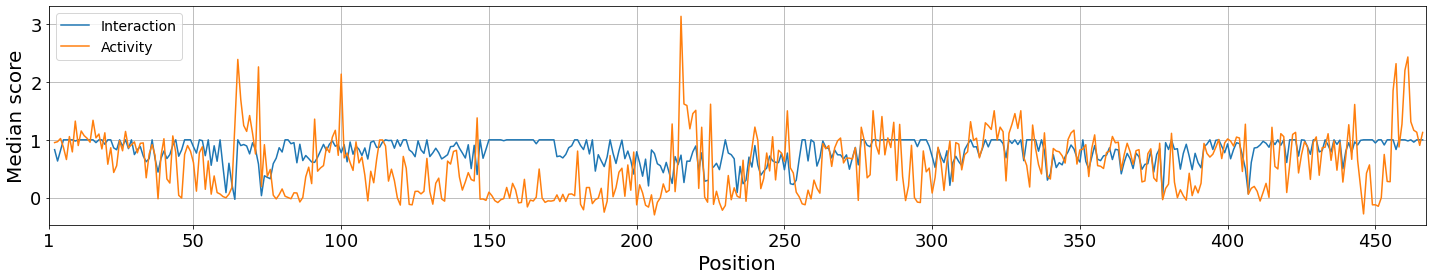

In [52]:
# Create a single subplot with the given figure size
fig, ax = plt.subplots(figsize=(20, 4))

# Plot each line with appropriate data
ax.plot(med_scores_low_se['position'], med_scores_low_se['score_interaction'], label='Interaction')
#ax.plot(med_scores_low_se['position'], med_scores_low_se['score_abundance'], label='Abundance')
ax.plot(med_scores_low_se['position'], med_scores_low_se['score_activity'], label='Activity')

# Set labels and other plot properties
ax.set_xlabel('Position')
ax.set_ylabel('Median score')
ax.grid(True)
ax.set_xlim(1, 466)
ax.set_yticks([0, 1, 2, 3])

x_labels= ['1','50', '100', '150','200','250', '300', '350',  '400', '450']
ax.set_xticks([0, 49, 99, 149, 199, 249, 299, 349, 399, 449])
ax.set_xticklabels(x_labels)
#ax.set_ylim(-0.2, 2)  # Uncomment if you need to set specific y-limits

# Add legend
ax.legend(fontsize=14, loc='upper left')

# Adjust layout to fit everything
fig.tight_layout()

# Show plot
plt.show()

## Line plot - interaction, abundance, activity

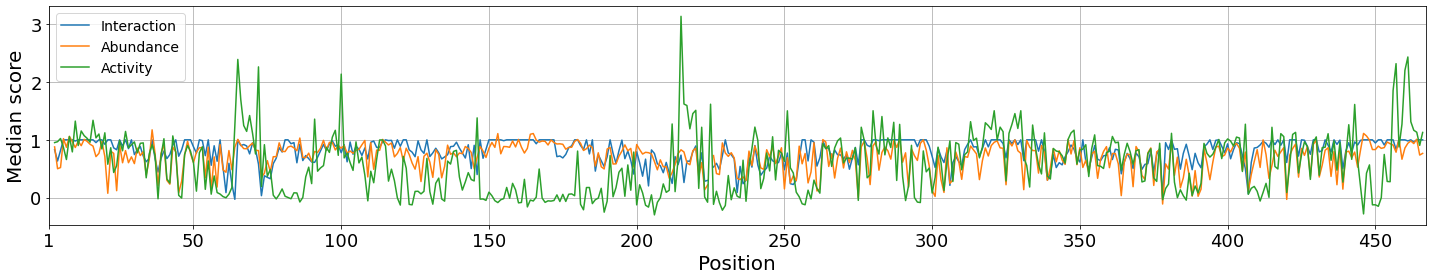

In [53]:
# Create a single subplot with the given figure size
fig, ax = plt.subplots(figsize=(20, 4))

# Plot each line with appropriate data
ax.plot(med_scores_low_se['position'], med_scores_low_se['score_interaction'], label='Interaction')
ax.plot(med_scores_low_se['position'], med_scores_low_se['score_abundance'], label='Abundance')
ax.plot(med_scores_low_se['position'], med_scores_low_se['score_activity'], label='Activity')

# Set labels and other plot properties
ax.set_xlabel('Position')
ax.set_ylabel('Median score')
ax.grid(True)
ax.set_xlim(1, 466)
ax.set_yticks([0, 1, 2, 3])

x_labels= ['1','50', '100', '150','200','250', '300', '350',  '400', '450']
ax.set_xticks([0, 49, 99, 149, 199, 249, 299, 349, 399, 449])
ax.set_xticklabels(x_labels)
#ax.set_ylim(-0.2, 2)  # Uncomment if you need to set specific y-limits

# Add legend
ax.legend(fontsize=14, loc='upper left')

# Adjust layout to fit everything
fig.tight_layout()

# Show plot
plt.show()

## Scatterplot abundance and interaction

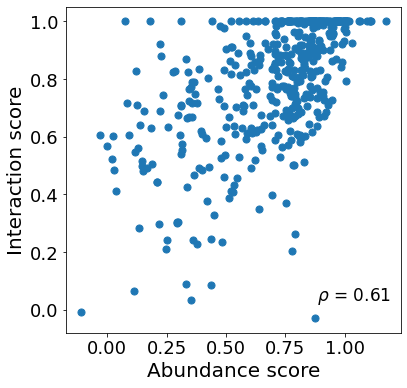

In [54]:
# Plotting the correlation between median interaction and abundance (capped at 1)

fig, ax = plt.subplots(figsize=(6,6))


plt.scatter(med_scores_low_se['score_abundance'], med_scores_low_se['score_interaction'], s=50)
plt.ylabel('Interaction score')
plt.xlabel('Abundance score')

#spearman's correlation
filtered = med_scores_low_se[['score_interaction', 'score_abundance']].dropna()
spearman = spearman_output(filtered['score_abundance'], filtered['score_interaction'])
plt.annotate(fr'$\rho$ = {spearman:.2f}', xy=(0.75, 0.1),xycoords='axes fraction', fontsize=17) 


plt.savefig('output/correlation_abu_int_med.png',dpi=600, facecolor='w',bbox_inches='tight')

### Residues within 4 Å of GKRP colored red

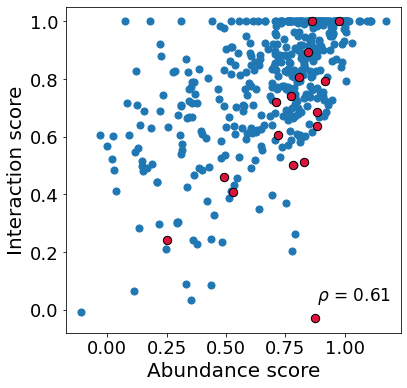

In [55]:
# Plotting the correlation between median interaction and abundance (capped at 1)

fig, ax = plt.subplots(figsize=(6,6))


plt.scatter(med_scores_low_se['score_abundance'], med_scores_low_se['score_interaction'], s=50)
plt.ylabel('Interaction score')
plt.xlabel('Abundance score')

#spearman's correlation
filtered = med_scores_low_se[['score_interaction', 'score_abundance']].dropna()
spearman = spearman_output(filtered['score_abundance'], filtered['score_interaction'])
plt.annotate(fr'$\rho$ = {spearman:.2f}', xy=(0.75, 0.1),xycoords='axes fraction', fontsize=17) 

# plotting positions within 4Å
highlight_positions = [47, 51, 63, 67, 141, 143, 186, 196, 198, 199, 242, 243, 244, 245, 247, 251]

# Ensure position column exists and filter valid data
df = med_scores_low_se.dropna(subset=['score_abundance', 'score_interaction'])
highlighted = df[df['position'].isin(highlight_positions)]
plt.scatter(highlighted['score_abundance'], highlighted['score_interaction'], s=70, color='crimson', edgecolor='black', label='Selected positions')


plt.savefig('output/correlation_abu_int_med_4å_res_color.png',dpi=600, facecolor='w',bbox_inches='tight')


# 2D histogram (uncapped scores)

In [56]:
#Custom color map
Wistia = mpl.cm.get_cmap('YlOrBr', 256)
newcolors = Wistia(np.linspace(0, 1, 256))
white = np.array([255/256, 255/256, 255/256, 1])
newcolors[:1, :] = white
newcmp = ListedColormap(newcolors)

In [57]:
scores_inner_int_abu_low_se_uncapped = scores_low_se_uncapped.dropna(subset=['score_interaction', 'score_abundance'])

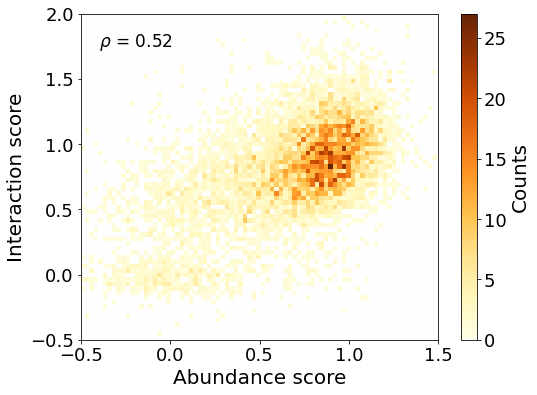

In [58]:
fig = plt.subplots(figsize = (8, 6))

plt.hist2d(scores_inner_int_abu_low_se_uncapped["score_abundance"], scores_inner_int_abu_low_se_uncapped["score_interaction"], bins=100, cmap=newcmp)
cbar= plt.colorbar(label="Counts")


plt.ylabel("Interaction score")
plt.xlabel("Abundance score")



#plt.legend(loc='lower right',fontsize=16)
plt.ylim(-0.5, 2)
plt.xlim(-0.5, 1.5)

spearman = spearman_output(scores_inner_int_abu_low_se_uncapped['score_abundance'], scores_inner_int_abu_low_se_uncapped['score_interaction'])
plt.annotate(fr'$\rho$ = {spearman:.2f}', xy=(0.05,0.9),xycoords='axes fraction', fontsize=17) 



plt.savefig('output/GCK_abu_int_2d_histogram.png',dpi=600, facecolor='w',bbox_inches='tight')

## Variants w. abu. >0.5 cluster at int. bt. 0 and 0.5 --> why?

In [59]:
# Filter to get variants with abundance score below 0.5 
low_abu = scores_low_se.loc[scores_low_se['score_abundance'] < 0.5]

# Filter to get variants with interaction score below 0.5 (using dataset of variants with abu. score <0.5)
low_abu_int = low_abu.loc[low_abu['score_interaction'] < 0.5]


In [60]:
# To ensure that no aa_var, aa_ref or position rows are NaN due to missing scores in the activity df
low_abu_int = split_hgvs_pro(low_abu_int)

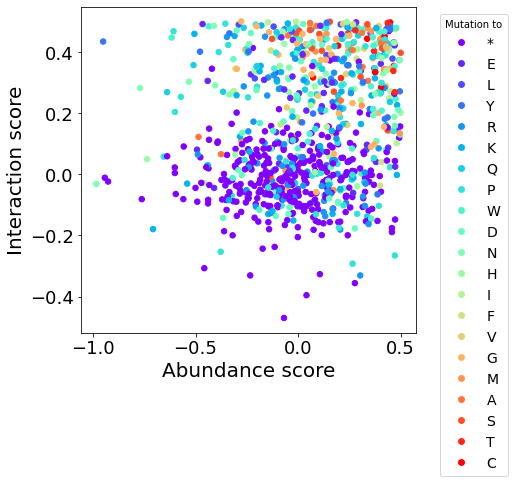

In [61]:
# Map categorical 'aa_var' values to numbers
unique_categories = low_abu_int['aa_var'].unique()
category_to_number = {cat: i for i, cat in enumerate(unique_categories)}
low_abu_int['aa_var_numeric'] = low_abu_int['aa_var'].map(category_to_number)

# Create a colormap for categorical variables
cmap = plt.cm.get_cmap('rainbow', len(unique_categories))

# Create figure and axis
fig, ax1 = plt.subplots(figsize=(6, 6))

# Scatter plot colored by 'aa_var'
sc1 = ax1.scatter(low_abu_int['score_abundance'], low_abu_int['score_interaction'],  
                  s=30, c=low_abu_int['aa_var_numeric'], cmap=cmap)

ax1.set_xlabel('Abundance score')
ax1.set_ylabel('Interaction score')

# Create a legend for categorical coloring
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=cmap(i), markersize=8) 
           for i in range(len(unique_categories))]
ax1.legend(handles, unique_categories, title="Mutation to", loc="upper left", bbox_to_anchor=(1.05, 1))

plt.savefig('output/clustering_nonsense.png',dpi=600, facecolor='w',bbox_inches='tight')

## 2D histogram without nonsense variants (uncapped)

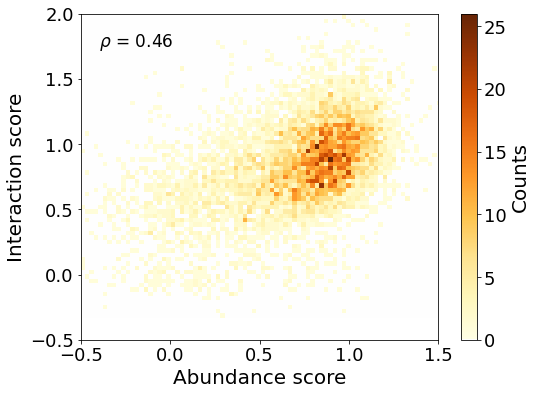

In [62]:
filtered_data = scores_inner_int_abu_low_se_uncapped[scores_inner_int_abu_low_se_uncapped['aa_var'] != '*']


fig = plt.subplots(figsize = (8, 6))

plt.hist2d(filtered_data["score_abundance"], filtered_data["score_interaction"], bins=100, cmap=newcmp)
cbar= plt.colorbar(label="Counts")


plt.ylabel("Interaction score")
plt.xlabel("Abundance score")



#plt.legend(loc='lower right',fontsize=16)
plt.ylim(-0.5, 2)
plt.xlim(-0.5, 1.5)

spearman = spearman_output(filtered_data['score_abundance'], filtered_data['score_interaction'])
plt.annotate(fr'$\rho$ = {spearman:.2f}', xy=(0.05,0.9),xycoords='axes fraction', fontsize=17) 



plt.savefig('output/GCK_abu_int_2d_histogram_no-nonsense.png',dpi=600, facecolor='w',bbox_inches='tight')

# Correlation with Kd from paper

Paper: https://portlandpress.com/biochemj/article/440/2/203/45611/Mutational-analysis-of-allosteric-activation-and

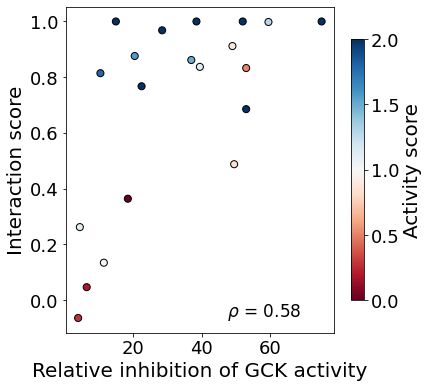

In [63]:
fig, ax2 = plt.subplots(1,1,figsize=(6,6))

cmap = plt.get_cmap('RdBu')
cmap.set_bad(color = 'grey')



# Plotting inhibition with S6P
sc1 =ax2.scatter(gkrp_inhibition['GKRP_S6P'], gkrp_inhibition['score_interaction'], s=50, c=gkrp_inhibition['score_activity'], cmap=cmap, vmin=0, vmax=2,edgecolors='black')
ax2.set_ylabel('Interaction score')
ax2.set_xlabel('Relative inhibition of GCK activity')
#ax2.set_title('GKRP inhibition with S6P', fontsize=20)

spearman = spearman_output(gkrp_inhibition['score_interaction'], gkrp_inhibition['GKRP_S6P'])
ax2.annotate(fr'$\rho$ = {spearman:.2f}', xy=(0.6,0.05),xycoords='axes fraction', fontsize=17) 

cbar = fig.colorbar(sc1, ax=ax2, shrink=0.8)
cbar.set_label('Activity score')

plt.savefig('output/GCK_GKRP_inhibition_activity.png',dpi=600, facecolor='w',bbox_inches='tight')

# Variants from reverse two-hybrid paper

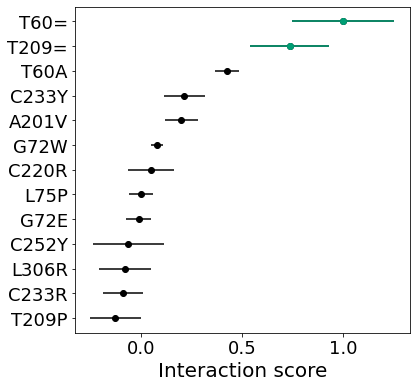

In [64]:
#reverse order so plotted in correct order
reverse_y2h = reverse_y2h.sort_values(by='score_interaction', ascending=True)

test_range = range(1, len(reverse_y2h.index)+1)


fig,ax=plt.subplots(1,1,figsize=(6,6))


ax.set_yticks(test_range)
ax.set_yticklabels(reverse_y2h['variant_x'])

plt.xlabel('Interaction score')

 
# Horizontal version
plt.plot(reverse_y2h['score_interaction'], test_range,"o", color='black')
plt.yticks(test_range, reverse_y2h['variant_x'])
plt.errorbar(reverse_y2h['score_interaction'], test_range, yerr=None, xerr= reverse_y2h['se_x'], linestyle='none', color='black')


# color synonymous variants green
highlight_variants = ['T60=', 'T209=']
highlight_df = reverse_y2h[reverse_y2h['variant'].isin(highlight_variants)]
highlight_positions = [reverse_y2h.index.get_loc(idx)+1 for idx in highlight_df.index]

plt.plot(
    highlight_df['score_interaction'], highlight_positions,
    "o", color='#009E74', label='T60= / T209='
)
plt.errorbar(
    highlight_df['score_interaction'], highlight_positions,
    xerr=highlight_df['se_x'], linestyle='none', color='#009E74'
)


plt.savefig('output/reverse_y2h_variants.png',dpi=600, facecolor='w',bbox_inches='tight')

# Plotting interaction based on data from PDB 4LC9

4Å cutoff

In [65]:
from Bio import PDB
import numpy as np
import matplotlib.pyplot as plt

# PDB file and parameters
pdb_id = "4LC9"
pdb_filename = f"{pdb_id}.pdb"
gck_chain_id = "B"  # GCK Chain
gkrp_chain_id = "A"  # GKRP Chain (Corrected)
distance_cutoff = 4.0 

# Load PDB structure
parser = PDB.PDBParser(QUIET=True)
structure = parser.get_structure(pdb_id, pdb_filename)

# Extract chains
gck_chain = structure[0][gck_chain_id]
gkrp_chain = structure[0][gkrp_chain_id]

# Get actual residue numbers from the PDB file
gck_residues = [res.id[1] for res in gck_chain if res.id[0] == " "]

# Create a mapping from PDB residue numbers → sequence index
residue_index_map = {res_id: i for i, res_id in enumerate(gck_residues)}

# Find interacting residues
interacting_residues = set()
for gck_res in gck_chain:
    if gck_res.id[0] != " ":  # Skip heteroatoms
        continue
    for gkrp_res in gkrp_chain:
        if gkrp_res.id[0] != " ":
            continue
        for gck_atom in gck_res:
            for gkrp_atom in gkrp_res:
                distance = gck_atom - gkrp_atom
                if distance < distance_cutoff:
                    interacting_residues.add(gck_res.id[1])

# Keep interacting residues as PDB numbers (not sequence indices)
mapped_interacting_residues = sorted(interacting_residues)

print("Corrected Interacting Residues (Sorted, PDB Numbering):", mapped_interacting_residues)


Corrected Interacting Residues (Sorted, PDB Numbering): [47, 51, 63, 67, 141, 143, 186, 196, 198, 199, 242, 243, 244, 245, 247, 251]


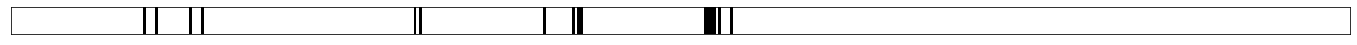

In [66]:
# Example list of sequence positions that should be colored black (your input list)
black_positions = mapped_interacting_residues

# Sequence length (adjust based on your GCK sequence length)
sequence_length = 466  # Modify with the correct length of your sequence

# Initialize an array with all white (0) positions
interaction_array = np.zeros(sequence_length)

# Set the positions in the list to black (1)
for pos in black_positions:
    interaction_array[pos - 1] = 1  # Adjust for zero-based indexing (if needed)

# Reshape the array to match the shape of the previous plot
interaction_matrix = interaction_array.reshape(1, -1)

# Create the figure
fig, ax1 = plt.subplots(1, 1, figsize=(24, 0.5))

# Define the colormap: white (0) for non-interacting and black (1) for interacting
cmap = ListedColormap(["white", "black"])

# Plot the interaction array
ax1.imshow(interaction_matrix, aspect='auto', cmap=cmap, vmin=0, vmax=1, interpolation='nearest')

# Set y-ticks and x-ticks as empty (just like the example you provided)
ax1.set_yticks([])
ax1.set_xticks([])

# Adjust x-axis to fit the entire sequence
ax1.set_xlim(-0.5, sequence_length - 0.5)

plt.savefig("output/gck_gkrp_interaction_strip_4Å.png", dpi=600, transparent=True, bbox_inches='tight')


# Display the plot
plt.show()


Residues 141 and 143 interact in the structure, and they also have slightly low median interaction scores. However, it looks misaligned because residue 145 has a lower median, but this is likely because this is a proline residue, which is not part of the interaction interface but affects abundance.

# Delta - interaction-abundance

delta = interaction_score - abundance_score
 
Interaction mostly affected --> negative delta

Potential GKRP stabilization --> positive delta



In [67]:
scores_low_se['delta_int_abu'] = scores_low_se['score_interaction'] - scores_low_se['score_abundance']

In [68]:
# Include rosetta data

scores_low_se = pd.merge(scores_low_se, rosetta_1v4t, how='left', on='variant')


## Median delta

In [69]:
# Make column with median delta
median_delta_int_abu = scores_low_se.groupby('position')['delta_int_abu'].median().reset_index()

all_positions = pd.DataFrame({'position': range(1, 466)})

median_delta_int_abu = pd.merge(all_positions, median_delta_int_abu, on='position', how='left')

In [70]:
# to ensure no NaN in position column

scores_low_se = split_hgvs_pro(scores_low_se)


## Raincloud plots

In [71]:
# Create group labels
scores_low_se['delta_group'] = scores_low_se['delta_int_abu'].apply(lambda x: 'delta > 0.5' if x > 0.5 else ('delta < -0.5' if x < -0.5 else 'delta neutral'))


In [72]:
# Calculate delta and create group labels in rasa df
rasa_1v4t['delta_int_abu'] = rasa_1v4t['score_interaction'] - rasa_1v4t['score_abundance']
rasa_1v4t['delta_group'] = rasa_1v4t['delta_int_abu'].apply(lambda x: 'delta > 0.5' if x > 0.5 else ('delta < -0.5' if x < -0.5 else 'delta neutral'))


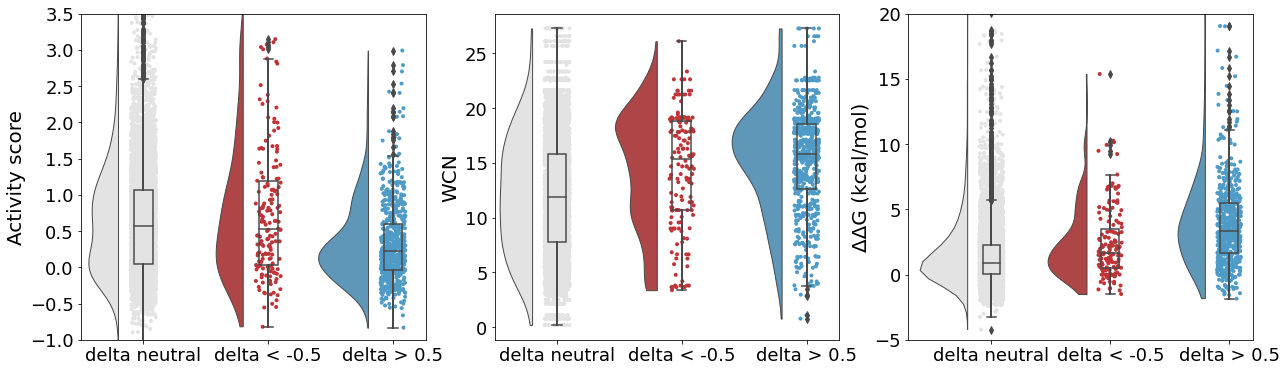

In [73]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(21,6))



# Activity
dx1 = "delta_group"; dy1 = "score_activity"; ort = "v"; pal = "Set2"; sigma = .3

ax1 = pt.RainCloud(x=dx1, y=dy1, data = scores_low_se, palette = ['#e3e3e3', '#C03438','#4F9BC7'],
               bw = sigma,width_viol = 0.8, ax = ax1, orient = ort,point_size=4)

ax1.set_ylabel('Activity score')
ax1.set_xlabel('')
ax1.set_ylim([-1, 3.5])


#WCN
dx2 = "delta_group"; dy2 = "WCN"; ort = "v"; pal = "Set2"; sigma = .3

ax2 = pt.RainCloud(x=dx2, y=dy2, data = rasa_1v4t, palette = ['#e3e3e3', '#C03438','#4F9BC7'],
               bw = sigma,width_viol = 0.8, ax = ax2, orient = ort,point_size=4)

ax2.set_ylabel('WCN')
ax2.set_xlabel('')


# ddG
dx3 = "delta_group"; dy3 = "ddG_1v4t"; ort = "v"; pal = "Set2"; sigma = .3

ax3 = pt.RainCloud(x=dx3, y=dy3, data = scores_low_se, palette = ['#e3e3e3', '#C03438','#4F9BC7'],
               bw = sigma,width_viol = 0.8, ax = ax3, orient = ort,point_size=4)

ax3.set_ylabel('\u0394\u0394G (kcal/mol)')
ax3.set_xlabel('')
ax3.set_ylim([-5, 20])
ax3.set_xlim([-0.7, 2.2])



plt.savefig('output/raincloud_activity_wcn_ddG.png',dpi=600, facecolor='w',bbox_inches='tight')

## Scatteplot w. delta color

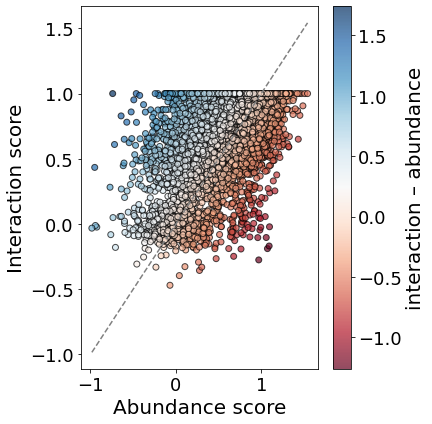

In [74]:
plt.figure(figsize=(6,6))
plt.scatter(scores_low_se['score_abundance'], scores_low_se['score_interaction'],
            c=scores_low_se['delta_int_abu'], cmap='RdBu', edgecolor='k', alpha=0.7)
plt.plot([scores_low_se[['score_abundance','score_interaction']].min().min(),
          scores_low_se[['score_abundance','score_interaction']].max().max()],
         [scores_low_se[['score_abundance','score_interaction']].min().min(),
          scores_low_se[['score_abundance','score_interaction']].max().max()],
         '--', color='gray')
plt.colorbar(label='interaction – abundance')
plt.xlabel('Abundance score')
plt.ylabel('Interaction score')
plt.tight_layout()

plt.savefig('output/delta_int_abu_scatter.png',dpi=600, facecolor='w', bbox_inches='tight')


## Delta barcode

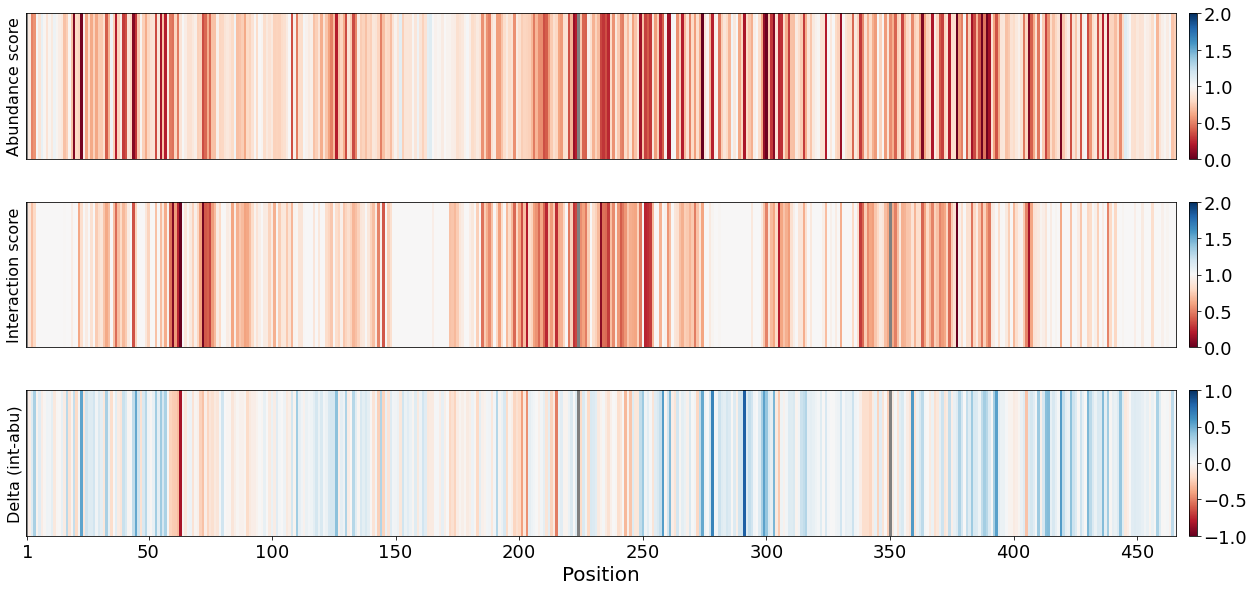

In [75]:
median_delta_int_abu_chimera = median_delta_int_abu.delta_int_abu.to_numpy()

fig, ((ax1),(ax2),(ax3)) = plt.subplots(3,1,figsize=(20,8))
plt.tight_layout()

cmap = plt.get_cmap('RdBu')
cmap.set_bad(color = 'grey')


shw1 = ax1.imshow(GCK_scores_med_abu.reshape(1,-1),aspect= 'auto',cmap=cmap,vmin=0,vmax=2,interpolation='nearest')
ax1.set_yticks([])
ax1.set_xticks([])
ax1.set_ylabel('Abundance score',fontsize=16)

shw2 = ax2.imshow(GCK_scores_med_low_se.reshape(1,-1),aspect= 'auto',cmap=cmap,vmin=0,vmax=2,interpolation='nearest')
ax2.set_yticks([])
ax2.set_xticks([])
ax2.set_ylabel('Interaction score',fontsize=16)

shw3 = ax3.imshow(median_delta_int_abu_chimera.reshape(1,-1),aspect= 'auto',cmap=cmap,vmin=-1,vmax=1,interpolation='nearest')
ax3.set_yticks([])
ax3.set_xticks([])
ax3.set_ylabel('Delta (int-abu)',fontsize=16)

x_labels= ['1','50', '100', '150','200','250', '300', '350',  '400', '450']
ax3.set_xticks([0, 49, 99, 149, 199, 249, 299, 349, 399, 449])
ax3.set_xticklabels(x_labels)
ax3.set_xlabel('Position')

#ax3.xaxis.set_ticks(np.arange(0, len(GCK_WT_sequence), 25))

bar1 = fig.colorbar(shw1, ax=ax1, location='right', pad=0.01)
bar2 = fig.colorbar(shw2, ax=ax2, location='right', pad=0.01)
bar3 = fig.colorbar(shw3, ax=ax3, location='right', pad=0.01)



plt.savefig('output/delta_int_abu_barcode.png',dpi=600, facecolor='w', bbox_inches='tight')


# Disease and gnomAD

## Raincloud

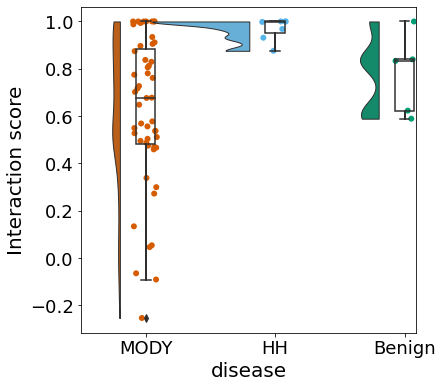

In [76]:
dx = "disease"; dy = "score_interaction"; ort = "v"; pal = "Set2"; sigma = .3
f, ax = plt.subplots(figsize=(6, 6))

ax1=pt.RainCloud(x = dx, y = dy, data = disease, palette = ['#d55c00','#56b4e9','#009e74'],
      bw = sigma,width_viol = 1.5, ax = ax, orient = ort,point_size=6)



#ax1.legend(loc='lower right')
ax1.set_ylabel('Interaction score')

plt.savefig('output/raincloud_disease.png',dpi=600, facecolor='w', bbox_inches='tight')


## Raincloud colored by abundance

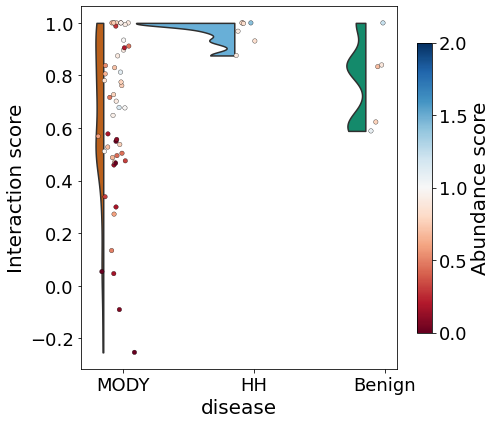

In [77]:
# Plot parameters
dx = "disease"
dy = "score_interaction"
color_var = "score_abundance"
ort = "v"
sigma = 0.3
palette = ['#d55c00', '#56b4e9', '#009e74']
order = ['MODY', 'HH', 'Benign']

cmap = plt.get_cmap('RdBu')
cmap.set_bad(color = 'grey')

# Filter data with valid interaction and abundance scores
filtered = disease.dropna(subset=[dy, color_var])

# Create plot
f, ax = plt.subplots(figsize=(7, 6))

# Plot half violins
pt.half_violinplot(
    x=dx, y=dy, data=filtered, palette=palette, bw=sigma,
    order=order, orient=ort, cut=0., scale='area', width=1.5, ax=ax, offset=0.15, inner=None
)



# Add jittered scatter points colored by abundance score
x_positions = {label: i for i, label in enumerate(order)}
for label in order:
    subset = filtered[filtered['disease'] == label]
    x_val = x_positions[label]
    jitter = np.random.normal(loc=x_val - 0.05, scale=0.05, size=len(subset))  # horizontal jitter
    ax.scatter(
        jitter,
        subset[dy],
        c=subset[color_var],
        cmap=cmap,
        s=20,
        linewidth=0.3,
        vmin=0, 
        vmax=2,
        edgecolors='black'
    )

# Colorbar
norm = mcolors.Normalize(vmin=0, vmax=2)
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = f.colorbar(sm, ax=ax, shrink=0.8)
cbar.set_label('Abundance score')

cbar.set_ticks([0.0, 0.5, 1.0, 1.5, 2.0])


# Final touches
ax.set_ylabel('Interaction score')
ax.set_xticks(range(len(order)))
ax.set_xticklabels(order)
plt.tight_layout()
plt.savefig('output/raincloud_disease_abundance.png',dpi=600, facecolor='w', bbox_inches='tight')



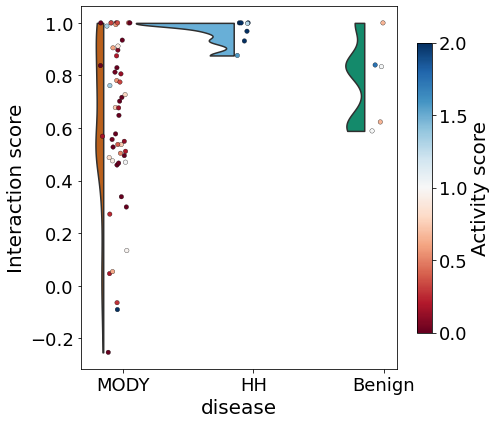

In [78]:
# Plot parameters
dx = "disease"
dy = "score_interaction"
color_var = "score_activity"
ort = "v"
sigma = 0.3
palette = ['#d55c00', '#56b4e9', '#009e74']
order = ['MODY', 'HH', 'Benign']

cmap = plt.get_cmap('RdBu')
cmap.set_bad(color = 'grey')

# Filter data with valid interaction and activity scores
filtered = disease.dropna(subset=[dy, color_var])

# Create plot
f, ax = plt.subplots(figsize=(7, 6))

# Plot half violins
pt.half_violinplot(
    x=dx, y=dy, data=filtered, palette=palette, bw=sigma,
    order=order, orient=ort, cut=0., scale='area', width=1.5, ax=ax, offset=0.15, inner=None
)



# Add jittered scatter points colored by abundance score
x_positions = {label: i for i, label in enumerate(order)}
for label in order:
    subset = filtered[filtered['disease'] == label]
    x_val = x_positions[label]
    jitter = np.random.normal(loc=x_val - 0.05, scale=0.05, size=len(subset))  # horizontal jitter
    ax.scatter(
        jitter,
        subset[dy],
        c=subset[color_var],
        cmap=cmap,
        s=20,
        linewidth=0.3,
        vmin=0, 
        vmax=2,
        edgecolors='black'
    )

# Colorbar
norm = mcolors.Normalize(vmin=0, vmax=2)
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = f.colorbar(sm, ax=ax, shrink=0.8)
cbar.set_label('Activity score')

cbar.set_ticks([0.0, 0.5, 1.0, 1.5, 2.0])


# Final touches
ax.set_ylabel('Interaction score')
ax.set_xticks(range(len(order)))
ax.set_xticklabels(order)
plt.tight_layout()
plt.savefig('output/raincloud_disease_activity.png',dpi=600, facecolor='w', bbox_inches='tight')



## ROC-AUC

### activity vs. minimum of three scores

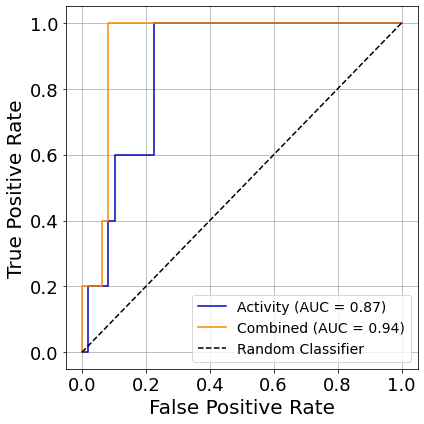

In [79]:

# Drop any rows with missing values in the columns of interest:
cols = ['score_activity', 'score_abundance', 'score_interaction', 'label']
df2 = disease[cols].dropna().copy()

# Extract true labels and scores
y_true = df2['label'].values
activity_score = df2['score_activity'].values
abundance_score = df2['score_abundance'].values
interaction_score = df2['score_interaction'].values

# Combine the three scores:
# Pathogenic if ANY score is low → min of the three scores
combined_score = np.minimum.reduce([activity_score, abundance_score, interaction_score])

# ROC for activity score
fpr_act, tpr_act, _ = roc_curve(y_true, activity_score)
roc_auc_act = auc(fpr_act, tpr_act)

# ROC for combined score
fpr_comb, tpr_comb, _ = roc_curve(y_true, combined_score)
roc_auc_comb = auc(fpr_comb, tpr_comb)

# Plotting
plt.figure(figsize=(6, 6))
plt.plot(fpr_act, tpr_act, label=f'Activity (AUC = {roc_auc_act:.2f})', color='#0000B8')
plt.plot(fpr_comb, tpr_comb, label=f'Combined (AUC = {roc_auc_comb:.2f})', color='#fb8500')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.savefig('output/ROC_curve_act_comb.png',dpi=600, facecolor='w', bbox_inches='tight')


### individual scores vs. minimum of three scores

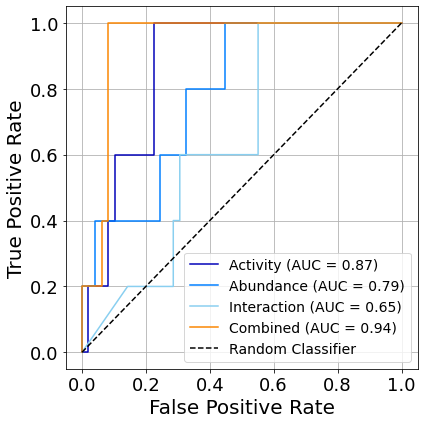

In [80]:
# Compute ROC and AUC for each score
fpr_activity, tpr_activity, _ = roc_curve(y_true, activity_score)
auc_activity = auc(fpr_activity, tpr_activity)

fpr_abundance, tpr_abundance, _ = roc_curve(y_true, abundance_score)
auc_abundance = auc(fpr_abundance, tpr_abundance)

fpr_interaction, tpr_interaction, _ = roc_curve(y_true, interaction_score)
auc_interaction = auc(fpr_interaction, tpr_interaction)

fpr_combined, tpr_combined, _ = roc_curve(y_true, combined_score)
auc_combined = auc(fpr_combined, tpr_combined)

# Plotting
plt.figure(figsize=(6, 6))
plt.plot(fpr_activity, tpr_activity, label=f'Activity (AUC = {auc_activity:.2f})', color='#0000B8')
plt.plot(fpr_abundance, tpr_abundance, label=f'Abundance (AUC = {auc_abundance:.2f})', color='#007FFF')
plt.plot(fpr_interaction, tpr_interaction, label=f'Interaction (AUC = {auc_interaction:.2f})', color='#89CFF0')
plt.plot(fpr_combined, tpr_combined, label=f'Combined (AUC = {auc_combined:.2f})', color='#fb8500')

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.savefig('output/ROC_curve_all_comb.png',dpi=600, facecolor='w', bbox_inches='tight')


### interaction and activity vs. combined

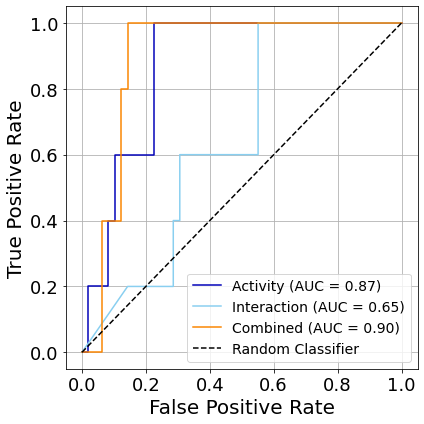

In [81]:
# Combine activity and interaction using min (i.e., "most pathogenic" interpretation)
combined_score = np.minimum(activity_score, interaction_score)

# Compute ROC and AUC
fpr_activity, tpr_activity, _ = roc_curve(y_true, activity_score)
auc_activity = auc(fpr_activity, tpr_activity)

fpr_interaction, tpr_interaction, _ = roc_curve(y_true, interaction_score)
auc_interaction = auc(fpr_interaction, tpr_interaction)

fpr_combined, tpr_combined, _ = roc_curve(y_true, combined_score)
auc_combined = auc(fpr_combined, tpr_combined)

# Plot
plt.figure(figsize=(6, 6))
plt.plot(fpr_activity, tpr_activity, label=f'Activity (AUC = {auc_activity:.2f})', color='#0000B8')
plt.plot(fpr_interaction, tpr_interaction, label=f'Interaction (AUC = {auc_interaction:.2f})', color='#89CFF0')
plt.plot(fpr_combined, tpr_combined, label=f'Combined (AUC = {auc_combined:.2f})', color='#fb8500')

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.savefig('output/ROC_curve_act_int.png',dpi=600, facecolor='w', bbox_inches='tight')


### abundance and activity vs. combined

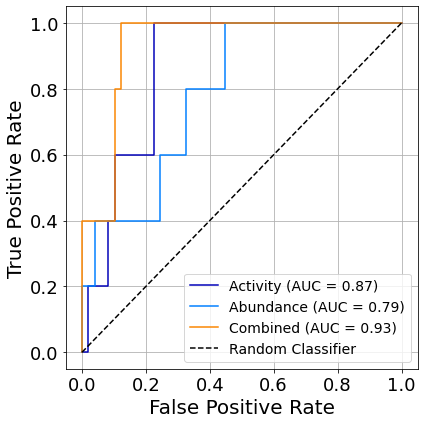

In [82]:
# Combine activity and abundance using min (i.e., "most pathogenic" interpretation)
combined_score = np.minimum(activity_score, abundance_score)

# Compute ROC and AUC
fpr_activity, tpr_activity, _ = roc_curve(y_true, activity_score)
auc_activity = auc(fpr_activity, tpr_activity)

fpr_abundance, tpr_abundance, _ = roc_curve(y_true, abundance_score)
auc_abundance = auc(fpr_abundance, tpr_abundance)

fpr_combined, tpr_combined, _ = roc_curve(y_true, combined_score)
auc_combined = auc(fpr_combined, tpr_combined)

# Plot
plt.figure(figsize=(6, 6))
plt.plot(fpr_activity, tpr_activity, label=f'Activity (AUC = {auc_activity:.2f})', color='#0000B8')
plt.plot(fpr_abundance, tpr_abundance, label=f'Abundance (AUC = {auc_abundance:.2f})', color='#007FFF')
plt.plot(fpr_combined, tpr_combined, label=f'Combined (AUC = {auc_combined:.2f})', color='#fb8500')

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.savefig('output/ROC_curve_act_abu.png',dpi=600, facecolor='w', bbox_inches='tight')


### abundance and interaction vs combined

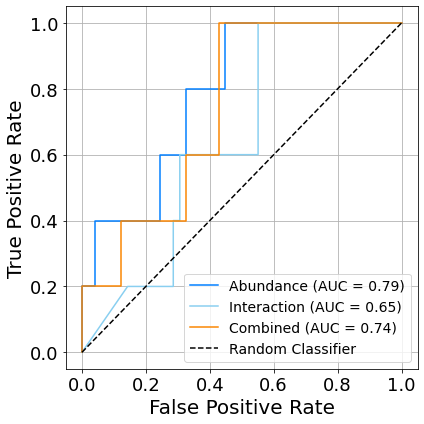

In [83]:
# Combine abundance and interaction using min (i.e., "most pathogenic" interpretation)
combined_score = np.minimum(abundance_score, interaction_score)

# Compute ROC and AUC
fpr_abundance, tpr_abundance, _ = roc_curve(y_true, abundance_score)
auc_abundance = auc(fpr_abundance, tpr_abundance)

fpr_interaction, tpr_interaction, _ = roc_curve(y_true, interaction_score)
auc_interaction = auc(fpr_interaction, tpr_interaction)

fpr_combined, tpr_combined, _ = roc_curve(y_true, combined_score)
auc_combined = auc(fpr_combined, tpr_combined)

# Plot
plt.figure(figsize=(6, 6))
plt.plot(fpr_abundance, tpr_abundance, label=f'Abundance (AUC = {auc_abundance:.2f})', color='#007FFF')
plt.plot(fpr_interaction, tpr_interaction, label=f'Interaction (AUC = {auc_interaction:.2f})', color='#89CFF0')
plt.plot(fpr_combined, tpr_combined, label=f'Combined (AUC = {auc_combined:.2f})', color='#fb8500')

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.savefig('output/ROC_curve_abu_int.png',dpi=600, facecolor='w', bbox_inches='tight')


## gnomAD

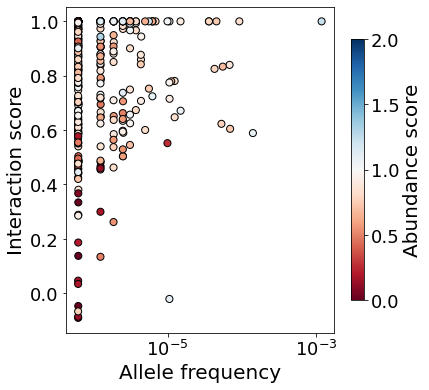

In [84]:

fig, ax = plt.subplots(figsize=(6,6))

cmap = plt.get_cmap('RdBu')
cmap.set_bad(color = 'grey')


plt.scatter(gnomad['allele_frequency'], gnomad['score_interaction'],s=50, edgecolor ='k',
           c=gnomad['score_abundance'], cmap=cmap,vmin=0,vmax=2)
plt.xlabel('Allele frequency')
plt.ylabel('Interaction score')
ax.set_xscale('log')

plt.colorbar(label="Abundance score", shrink=0.8)


plt.savefig('output/gnomad.png',dpi=600, facecolor='w', bbox_inches='tight')


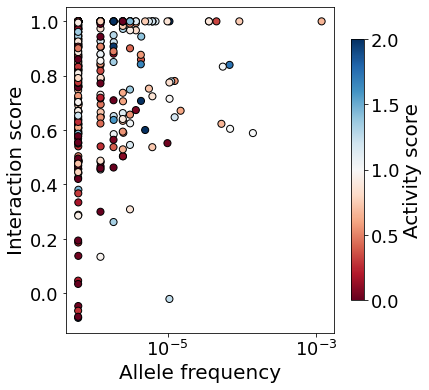

In [85]:

fig, ax = plt.subplots(figsize=(6,6))

cmap = plt.get_cmap('RdBu')
cmap.set_bad(color = 'grey')


plt.scatter(gnomad['allele_frequency'], gnomad['score_interaction'],s=50, edgecolor ='k',
           c=gnomad['score_activity'], cmap=cmap,vmin=0,vmax=2)
plt.xlabel('Allele frequency')
plt.ylabel('Interaction score')
ax.set_xscale('log')

plt.colorbar(label="Activity score", shrink=0.8)


plt.savefig('output/gnomad_activity.png',dpi=600, facecolor='w', bbox_inches='tight')


# Kinetics

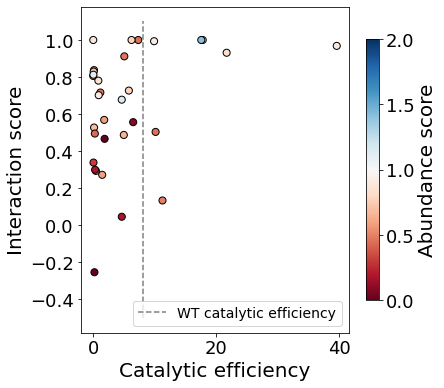

In [86]:
fig, ax = plt.subplots(figsize=(6,6))

cmap = plt.get_cmap('RdBu')
cmap.set_bad(color = 'grey')

plt.scatter(kinetics['catalytic_efficiency'], kinetics['score_interaction'],s=50, edgecolor ='k',
           c=kinetics['score_abundance'], cmap=cmap,vmin=0,vmax=2)
plt.xlabel('Catalytic efficiency')
plt.ylabel('Interaction score')

ax.plot([kinetics['catalytic_efficiency'][0],kinetics['catalytic_efficiency'][0]],[-0.5,1.1],'r--',color='grey', label='WT catalytic efficiency')
ax.legend(loc='lower right')

plt.colorbar(label="Abundance score", shrink=0.8)

plt.savefig('output/kinetics.png',dpi=600, facecolor='w', bbox_inches='tight')
